<a href="https://colab.research.google.com/github/Kim-jong-hoon/week-7-4/blob/main/day4_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 4 Lab: Building and Breaking a PID Controller

**Objective:** 이 실습의 목표는 단순한 PID 공식을 넘어, 실제 환경에서 마주치는 문제들을 해결하는 '견고한(Robust)' PID 제어기를 구축하는 것입니다. 우리는 순수한 PID 제어기의 실패 사례를 직접 목격하고, 이를 해결하는 코드를 단계별로 추가해 나갈 것입니다.

**Libraries:** `numpy`와 `matplotlib`만 사용합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# Helper function to plot results
def plot_results(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history['time'], history['setpoint'], 'k--', label='Setpoint')
    plt.plot(history['time'], history['pv'], 'b-', label='Process Variable (PV)')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

---
## Part 1: The Naive PID Controller

먼저 강의에서 배운 가장 기본적인 디지털 PID 제어기를 클래스로 구현합니다. 이 제어기는 몇 가지 순진한 가정을 하고 있습니다.
1.  `dt`는 항상 일정하다.
2.  미분항은 에러(Error)를 기반으로 계산한다.
3.  액추에이터(출력)에는 한계가 없다.

In [2]:
class NaivePID:
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint

        # State variables
        self.integral = 0.0
        self.previous_error = 0.0

    def update(self, pv, dt):
        error = self.setpoint - pv

        # --- STUDENT TO-DO (1/3): Implement the three PID terms ---
        # 순수한 디지털 PID 공식을 여기에 구현하세요.
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt

        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        # --- END TO-DO ---

        self.previous_error = error
        return output

### 시뮬레이션 환경

제어기를 테스트할 간단한 물리 시스템을 시뮬레이션합니다. 제어기의 `output`은 시스템의 가속도로 작용합니다.

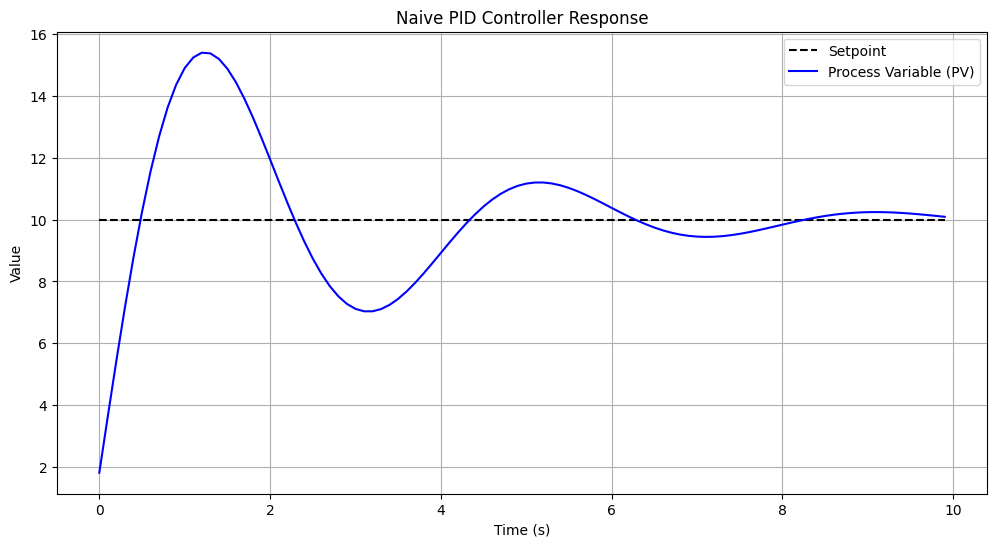

In [3]:
def run_simulation(controller, duration=10.0, dt=0.1):
    # System state
    pv = 0.0
    velocity = 0.0

    # Data logging
    history = {'time': [], 'pv': [], 'setpoint': []}

    for t in np.arange(0, duration, dt):
        output = controller.update(pv, dt)

        # Update system based on controller output
        velocity += output * dt
        pv += velocity * dt

        history['time'].append(t)
        history['pv'].append(pv)
        history['setpoint'].append(controller.setpoint)

    return history

# Test the Naive PID
naive_pid = NaivePID(Kp=3.0, Ki=2.0, Kd=1.5, setpoint=10.0)
history = run_simulation(naive_pid)
plot_results(history, "Naive PID Controller Response")

---
## Part 2: Breaking the Controller - The Failure Cases

이제 이 순수한 제어기가 실제 상황에서 어떻게 실패하는지 직접 목격해 보겠습니다.

### 실패 사례 1: 미분 킥 (Derivative Kick)

주행 중 목표 속도가 갑자기 변경되는 상황을 시뮬레이션합니다. `setpoint`가 중간에 바뀌면 D-term이 어떻게 반응하는지 관찰하세요.

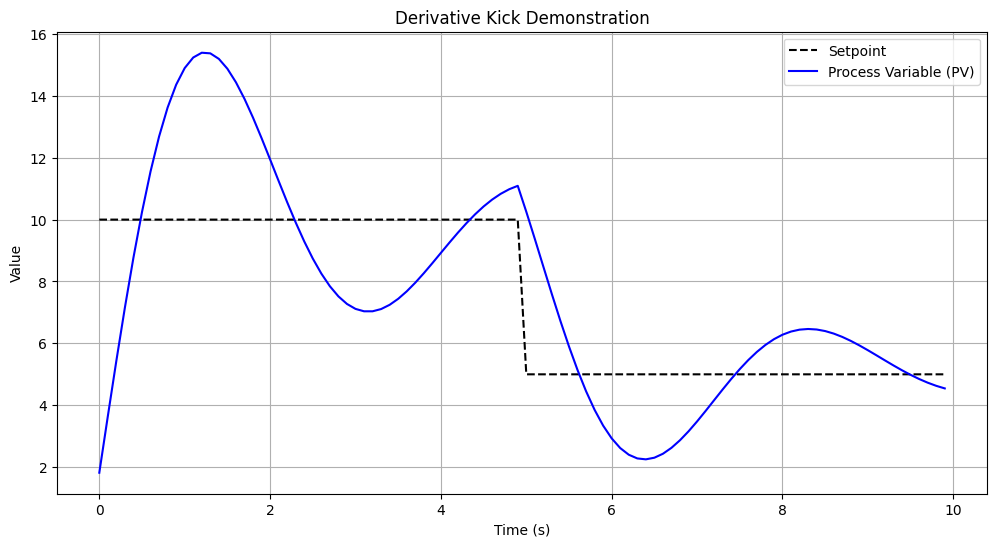

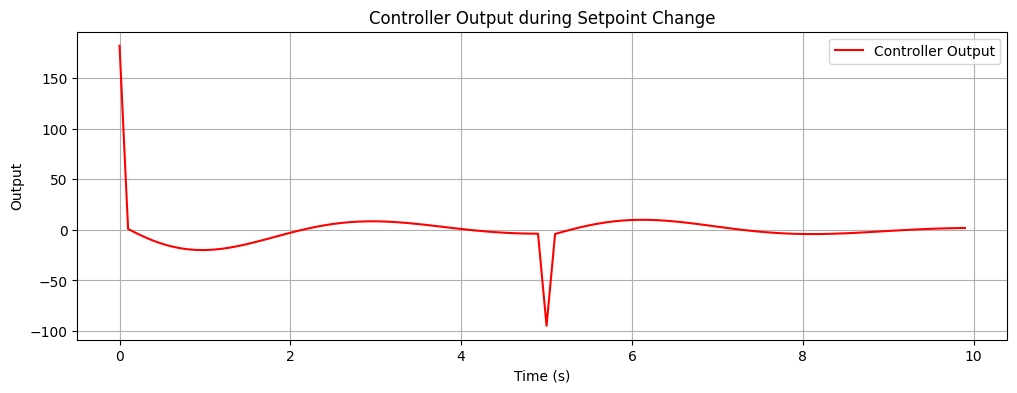

In [4]:
def run_simulation_with_kick(controller, duration=10.0, dt=0.1):
    pv = 0.0
    velocity = 0.0
    history = {'time': [], 'pv': [], 'setpoint': [], 'output': []}

    for t in np.arange(0, duration, dt):
        # Change setpoint at t=5s
        if t >= 5.0:
            controller.setpoint = 5.0

        output = controller.update(pv, dt)
        velocity += output * dt
        pv += velocity * dt

        history['time'].append(t)
        history['pv'].append(pv)
        history['setpoint'].append(controller.setpoint)
        history['output'].append(output)

    return history

kick_pid = NaivePID(Kp=3.0, Ki=2.0, Kd=1.5, setpoint=10.0)
kick_history = run_simulation_with_kick(kick_pid)

# Plot both PV and the controller output to see the kick
plot_results(kick_history, "Derivative Kick Demonstration")
plt.figure(figsize=(12, 4))
plt.plot(kick_history['time'], kick_history['output'], 'r-', label='Controller Output')
plt.title('Controller Output during Setpoint Change')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

**관찰:** Setpoint가 변경되는 5초 시점에서 Controller Output이 비정상적으로 크게 튀는 것을 볼 수 있습니다. 이것이 바로 '미분 킥'입니다.

### 실패 사례 2: 적분 와인드업 (Integral Windup)

이제 액추에이터에 물리적 한계가 있는 상황을 시뮬레이션합니다. 제어기 출력이 `[-10, 10]` 범위를 벗어날 수 없다고 가정합니다.

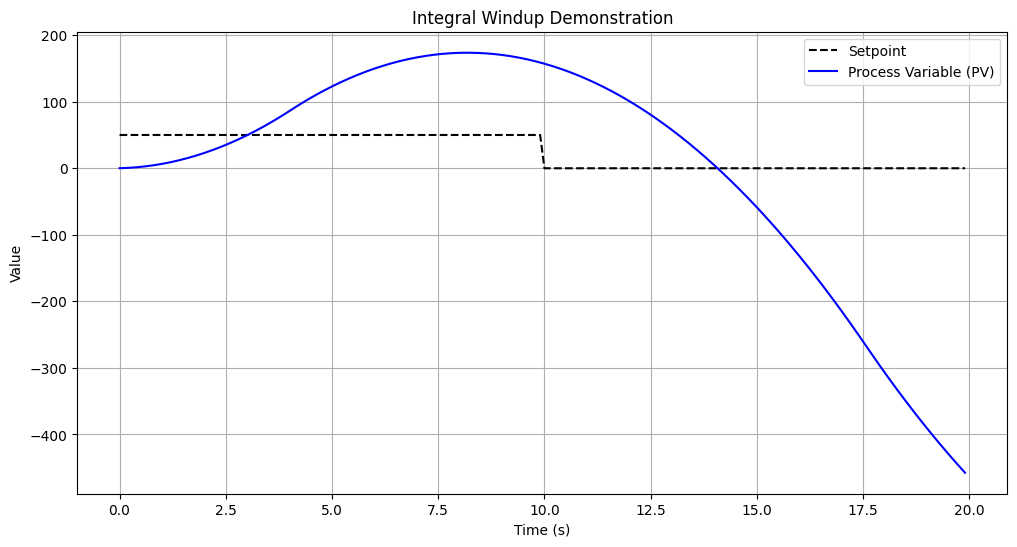

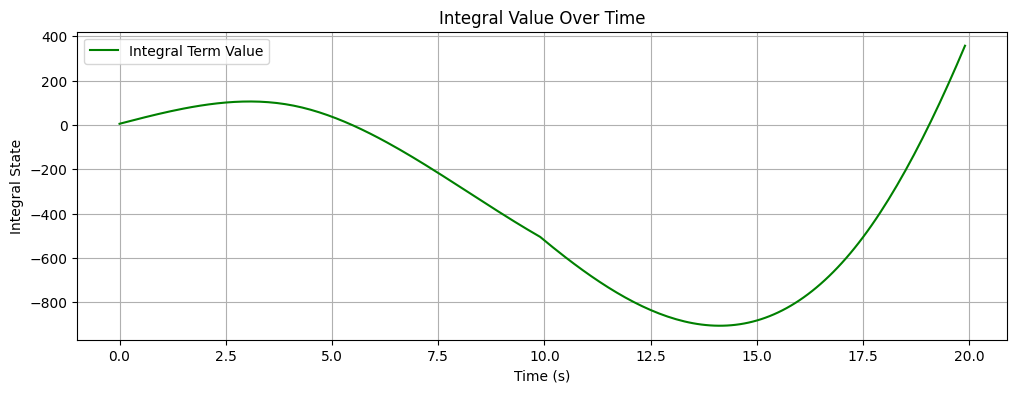

In [5]:
def run_simulation_with_saturation(controller, duration=20.0, dt=0.1):
    pv = 0.0
    velocity = 0.0
    output_limit = 10.0
    history = {'time': [], 'pv': [], 'setpoint': [], 'integral': []}

    # Set a high setpoint that will cause saturation
    controller.setpoint = 50.0

    for t in np.arange(0, duration, dt):
        # At t=10s, bring the setpoint back to a reachable value
        if t >= 10.0:
            controller.setpoint = 0.0

        output = controller.update(pv, dt)

        # Apply actuator saturation
        clamped_output = np.clip(output, -output_limit, output_limit)

        velocity += clamped_output * dt
        pv += velocity * dt

        history['time'].append(t)
        history['pv'].append(pv)
        history['setpoint'].append(controller.setpoint)
        history['integral'].append(controller.integral)

    return history

windup_pid = NaivePID(Kp=3.0, Ki=2.0, Kd=1.5, setpoint=50.0)
windup_history = run_simulation_with_saturation(windup_pid)

plot_results(windup_history, "Integral Windup Demonstration")
plt.figure(figsize=(12, 4))
plt.plot(windup_history['time'], windup_history['integral'], 'g-', label='Integral Term Value')
plt.title('Integral Value Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Integral State')
plt.legend()
plt.grid(True)
plt.show()

**관찰:**
1.  첫 10초 동안 Integral 값이 계속해서 거대하게 증가하는 것을 볼 수 있습니다.
2.  10초에 Setpoint가 0으로 돌아왔음에도 불구하고, PV가 0을 훨씬 지나쳐 심각한 오버슛을 일으킵니다. 이는 거대하게 '감겨버린(wound up)' Integral 값 때문입니다.

---

## Part 3: Building a Robust PID Controller

이제 우리가 발견한 문제들을 해결하는 견고한 PID 제어기 클래스를 만듭니다.

**개선 사항:**
1.  **측정값 기반 미분 (Derivative on Measurement):** 미분 킥을 방지합니다.
2.  **안티-와인드업 (Anti-Windup):** 적분 와인드업을 방지합니다.
3.  **가변 `dt` 처리:** 실제 시간을 측정하여 계산 정확도를 높입니다. (이 실습에서는 시뮬레이션의 편의를 위해 고정 `dt`를 사용하지만, 실제 코드에서는 `time.time()`을 사용해야 함을 인지합니다.)

In [6]:
class RobustPID:
    def __init__(self, Kp, Ki, Kd, setpoint, output_limits):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.min_out, self.max_out = output_limits

        # State variables
        self.integral = 0.0
        self.previous_pv = 0.0
        self.last_output = 0.0

    def update(self, pv, dt):
        if dt <= 0:
            return self.last_output

        error = self.setpoint - pv

        # --- STUDENT TO-DO (2/3): Implement P and D terms ---
        # P항은 그대로, D항은 '측정값 기반 미분'으로 구현하세요.
        p_term = self.Kp * error

        # Use derivative on measurement
        derivative = (pv - self.previous_pv) / dt
        d_term = -self.Kd * derivative
        # --- END TO-DO ---

        # --- STUDENT TO-DO (3/3): Implement I-term with Anti-Windup ---
        # I항을 계산하되, 안티-와인드업 로직을 추가하세요.
        # 힌트: 조건부 적분. 출력이 포화상태가 아닐 때만 적분을 수행합니다.

        # First, calculate the potential I-term
        i_term = self.Ki * self.integral

        # Calculate pre-saturated output
        output = p_term + i_term + d_term

        # Conditional integration for anti-windup
        if self.min_out < output < self.max_out:
            self.integral += error * dt
        # --- END TO-DO ---

        # Clamp the final output
        clamped_output = np.clip(output, self.min_out, self.max_out)

        # Update state for next iteration
        self.previous_pv = pv
        self.last_output = clamped_output

        return clamped_output

### 견고한 제어기 테스트

이제 동일한 와인드업 시나리오에서 `RobustPID`가 어떻게 동작하는지 확인해 봅시다.

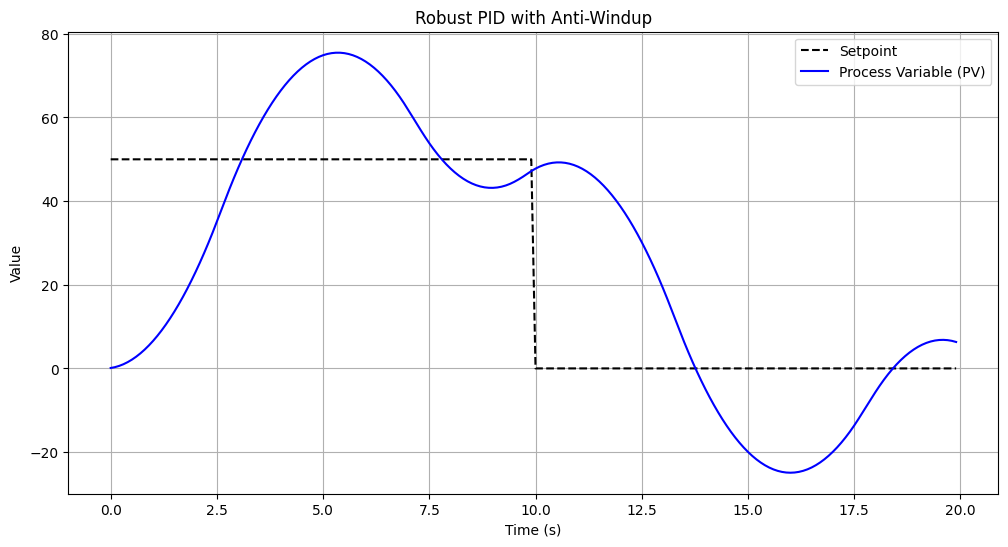

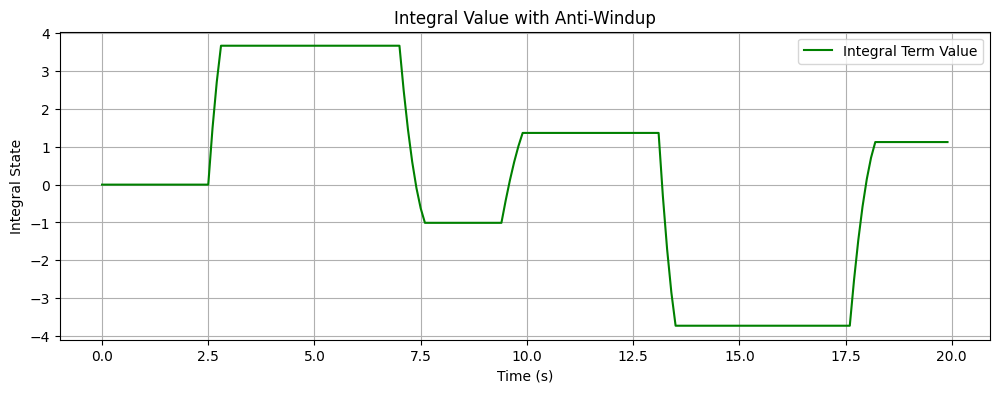

In [7]:
# Use the same saturation simulation, but with the RobustPID controller
robust_pid = RobustPID(Kp=3.0, Ki=2.0, Kd=1.5, setpoint=50.0, output_limits=(-10.0, 10.0))
robust_history = run_simulation_with_saturation(robust_pid)

plot_results(robust_history, "Robust PID with Anti-Windup")
plt.figure(figsize=(12, 4))
plt.plot(robust_history['time'], robust_history['integral'], 'g-', label='Integral Term Value')
plt.title('Integral Value with Anti-Windup')
plt.xlabel('Time (s)')
plt.ylabel('Integral State')
plt.legend()
plt.grid(True)
plt.show()

### 최종 분석 및 결론

**질문:**
1.  `RobustPID`의 오버슛이 `NaivePID`에 비해 어떻게 달라졌나요?
2.  두 번째 Integral 그래프에서, `RobustPID`의 Integral 값은 왜 더 이상 무한정 증가하지 않았나요?
3.  실제 자율주행차의 조향 제어기나 속도 제어기를 구현한다면, 왜 `RobustPID`와 같은 접근 방식이 필수적일지 자신의 언어로 설명해 보세요.

**결론:** 성공적인 PID 제어는 단순히 세 항의 공식을 구현하는 것을 넘어, 미분 킥, 와인드업, 시간 지연과 같은 현실 세계의 문제들을 해결하는 견고한 엔지니어링 설계를 요구합니다.